1. Get the data 
2. Divide de data
3. Discover
4. Prepare Data for the Machine Learning Model
5. Select and Train a model(Linear Regression or nearest neighboohood)
6. Fine Tuning of the model 
7. Evaluate the model and launch the model into production


Data Cleaning

**Duplicates & NaNs**: I started by removing duplicates from the data, checked for missing or NaN (not a number) values. It’s important to check for NaNs (and not just because it’s socially moral) because these cause errors in the machine learning models.

**Categorical Features**: There are a lot of categorical variables that are marked as N/A when a feature of the house is nonexistent. For example, when no alley is present. I identified all the cases where this was happening across the training and test data and replaced the N/As with something more descriptive.
N/As can cause errors with machine learning later down the line so get rid of them.

**Date Features**: For this exercise dates would be better used as categories and not integers. After all, it’s not so much the magnitude that we care about but rather that the dates represent different years. Solving this problem is simple, just convert the numeric dates to strings.

**Decoded Variables**: Some categorical variables had been number encoded. 

In [ ]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# create output folder
if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('output/session1'):
    os.makedirs('output/session1')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import missingno as msno


In [ ]:
# to make this notebook's output identical at every run
np.random.seed(42)

## Get the data

In [ ]:
housing = pd.read_csv('/content/train_set.csv') # change path (Github or similar)

In [ ]:
housing.shape

(5432, 22)

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5432 entries, 0 to 5431
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          5432 non-null   int64  
 1   Suburb         5432 non-null   object 
 2   Address        5432 non-null   object 
 3   Rooms          5432 non-null   int64  
 4   Type           5432 non-null   object 
 5   Price          5432 non-null   float64
 6   Method         5432 non-null   object 
 7   SellerG        5432 non-null   object 
 8   Date           5432 non-null   object 
 9   Distance       5432 non-null   float64
 10  Postcode       5432 non-null   float64
 11  Bedroom2       5432 non-null   float64
 12  Bathroom       5432 non-null   float64
 13  Car            5407 non-null   float64
 14  Landsize       5432 non-null   float64
 15  BuildingArea   2890 non-null   float64
 16  YearBuilt      3302 non-null   float64
 17  CouncilArea    4879 non-null   object 
 18  Lattitud

In [ ]:
housing["Type"].value_counts()

h    3765
u    1191
t     476
Name: Type, dtype: int64

In [ ]:
housing.describe()

,index,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,5432.000000,5432.000000,5.432000e+03,5432.000000,5432.000000,5432.000000,5432.000000,5407.000000,5432.000000,2890.000000,3302.000000,5432.000000,5432.000000,5432.000000
mean,2715.500000,2.937224,1.078470e+06,10.220692,3106.552835,2.917342,1.538660,1.630109,537.054676,163.462430,1965.219564,-37.809664,144.995491,7438.537555
std,1568.227662,0.951947,6.470654e+05,5.996967,95.185290,0.988414,0.704286,0.982855,1550.867601,843.189116,36.244398,0.079365,0.106382,4368.906756
min,0.000000,1.000000,1.450000e+05,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1830.000000,-38.174880,144.542370,389.000000
25%,1357.750000,2.000000,6.500000e+05,6.200000,3046.000000,2.000000,1.000000,1.000000,182.750000,92.000000,1940.000000,-37.856648,144.930800,4294.000000
50%,2715.500000,3.000000,9.015000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,450.000000,125.000000,1970.000000,-37.802635,145.000250,6543.000000
75%,4073.250000,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,654.250000,174.750000,1999.000000,-37.757238,145.059225,10331.000000
max,5431.000000,8.000000,8.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,75100.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


In [ ]:
## POSTCODE IS NOT NUMERIC, we should change it to categorical
housing['Postcode'] = pd.Categorical(housing.Postcode)

housing.YearBuilt = housing.YearBuilt.astype(str) # Train 
# ---- # Test

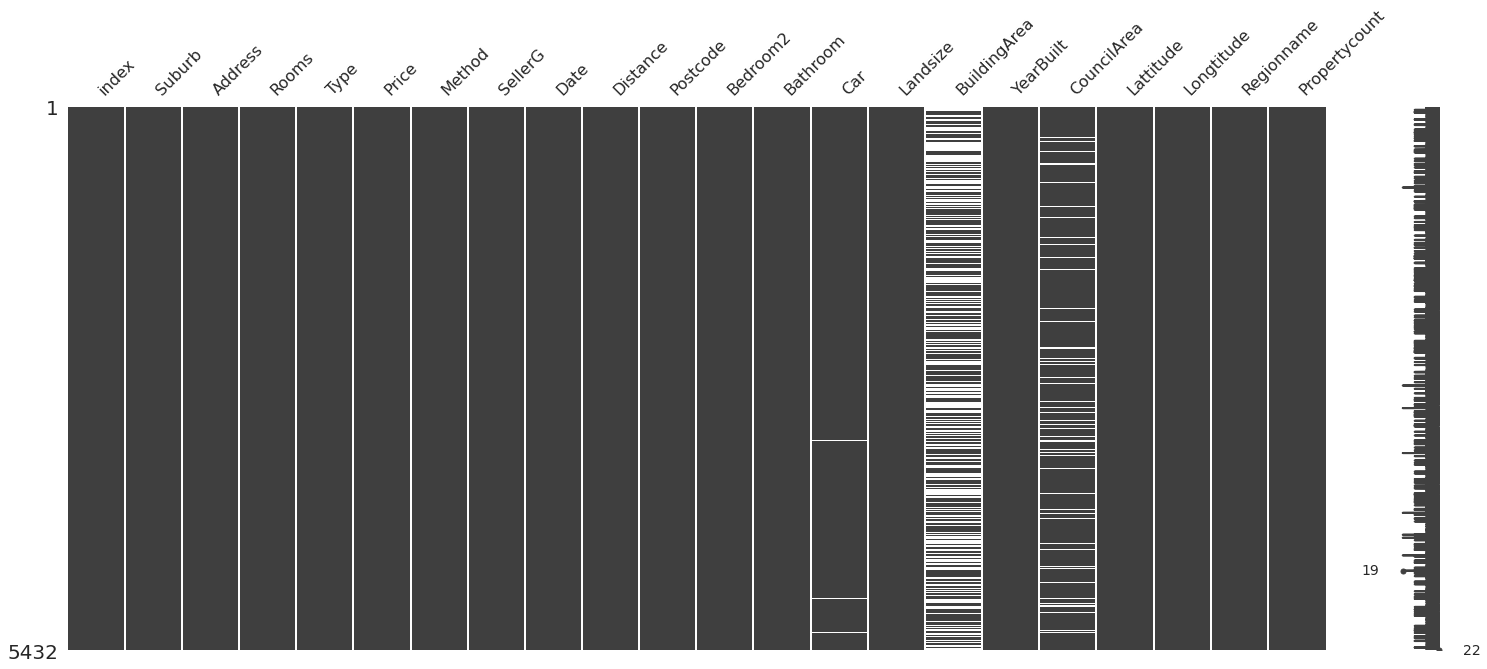

In [ ]:
import missingno as msno
msno.matrix(housing);

In [ ]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(housing)

,Total,Percent
BuildingArea,2542,46.80
CouncilArea,553,10.18
Car,25,0.46


## Divide into train - validation

There are several ways to divide your training data. Sometimes it is important to create a stratified sampling.

In [ ]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set),len(test_set)

(4346, 1086)

In [ ]:
## Create a function that divides the data with an id
## checks that id is not train and test set
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

## create an id base on latitude and longitude
housing_with_id["id"] = housing["Longtitude"] * 1000 + housing["Lattitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [ ]:
test_set.head()

,level_0,index,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
5,5,5,Coburg,4/34 Gladstone St,2,u,650000.0,S,Barry,29/04/2017,7.8,3058.0,2.0,1.0,1.0,136.0,81.0,1975.0,Moreland,-37.74490,144.97540,Northern Metropolitan,11204.0,144937.65510
11,11,11,Malvern East,2/25 Fisher St,3,t,1135000.0,S,Jellis,17/09/2016,11.2,3145.0,3.0,3.0,2.0,0.0,130.0,1988.0,Stonnington,-37.88120,145.05700,Southern Metropolitan,8801.0,145019.11880
12,12,12,Coburg North,27 Williams Rd,4,h,770000.0,S,Brad,13/05/2017,9.2,3058.0,4.0,1.0,1.0,545.0,NaN,nan,Moreland,-37.73040,144.96050,Northern Metropolitan,3445.0,144922.76960
16,16,16,Hawthorn East,1/27 Auburn Gr,3,h,1405000.0,S,Kay,20/05/2017,7.5,3123.0,3.0,2.0,2.0,185.0,185.0,1985.0,Boroondara,-37.82550,145.04810,Southern Metropolitan,6482.0,145010.27450
24,24,24,Oakleigh South,8 Cedar Ct,3,h,880000.0,S,Buxton,8/07/2017,15.5,3167.0,3.0,2.0,2.0,504.0,NaN,nan,Kingston,-37.94043,145.09314,South-Eastern Metropolitan,3692.0,145055.19957


In [ ]:
## divide using the scikit learn function
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

I plotted sales price on a histogram. The distribution of sale prices is right skewed, something that is expected. 
it might not be unusual to see a few houses that are relatively expensive.
positive Skewness the mean and median are grater than the mode similar to this dataset. Which means more houses were sold by less than the average price.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


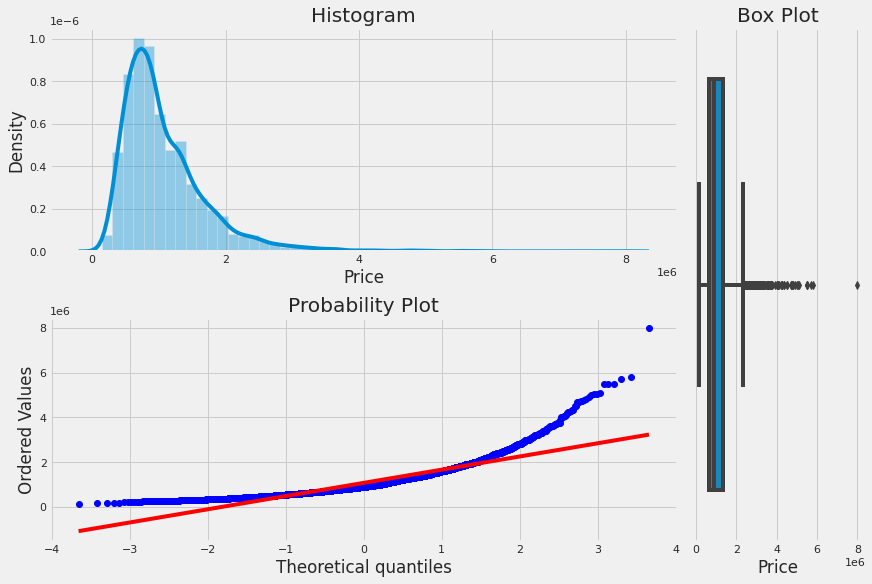

In [ ]:
def plotting_3_chart(df, feature): #added new 
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    
plotting_3_chart(housing, 'Price')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


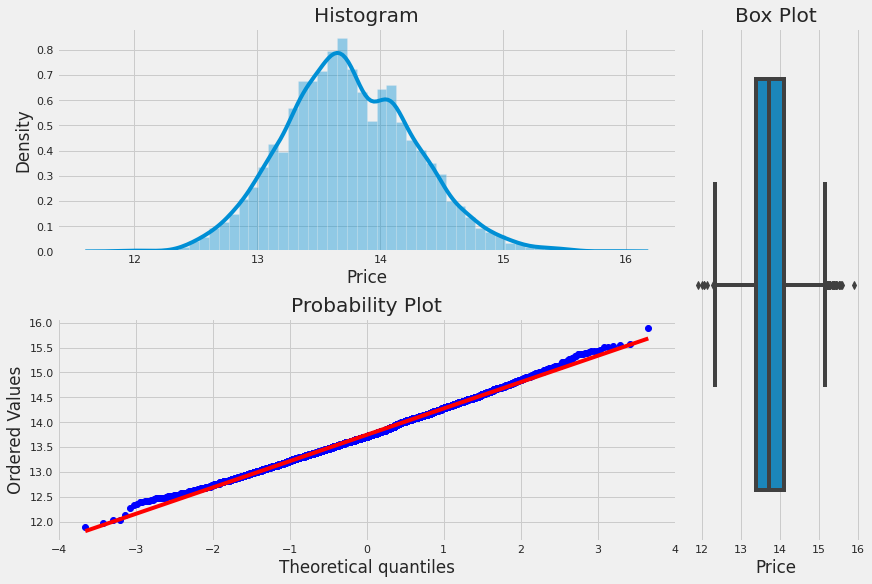

In [ ]:
## trainsforming target variable using numpy.log1p, 
housing["Price_log"] = np.log(housing.Price) #added new
x = housing.Price_log
housing["Price"] = housing["Price_log"]

## Plotting the newly transformed response variable
plotting_3_chart(housing, 'Price')

In [ ]:
#skewness and kurtosis
print("Skewness: " + str(housing['Price'].skew()))
print("Kurtosis: " + str(housing['Price'].kurt()))

Skewness: 0.19003522923818156
Kurtosis: 0.010409309456820282


In [ ]:
## Getting the correlation of all the features with target variable. 
(housing.corr()**2)["Price"].sort_values(ascending = False)[1:]

Price_log        1.000000
Rooms            0.314221
Bedroom2         0.274370
Bathroom         0.197569
Car              0.063727
Longtitude       0.057084
Lattitude        0.048159
Distance         0.024744
BuildingArea     0.004739
Propertycount    0.004028
Landsize         0.002287
index            0.000045
Name: Price, dtype: float64

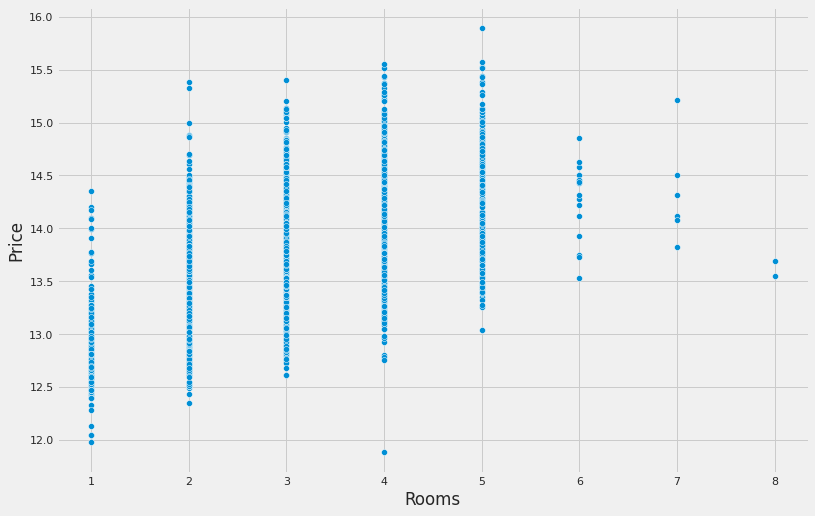

In [ ]:
def customized_scatterplot(y, x):
        ## Sizing the plot. 
    style.use('fivethirtyeight')
    plt.subplots(figsize = (12,8))
    ## Plotting target variable with predictor variable(Rooms)
    sns.scatterplot(y = y, x = x);

customized_scatterplot(housing.Price, housing.Rooms)

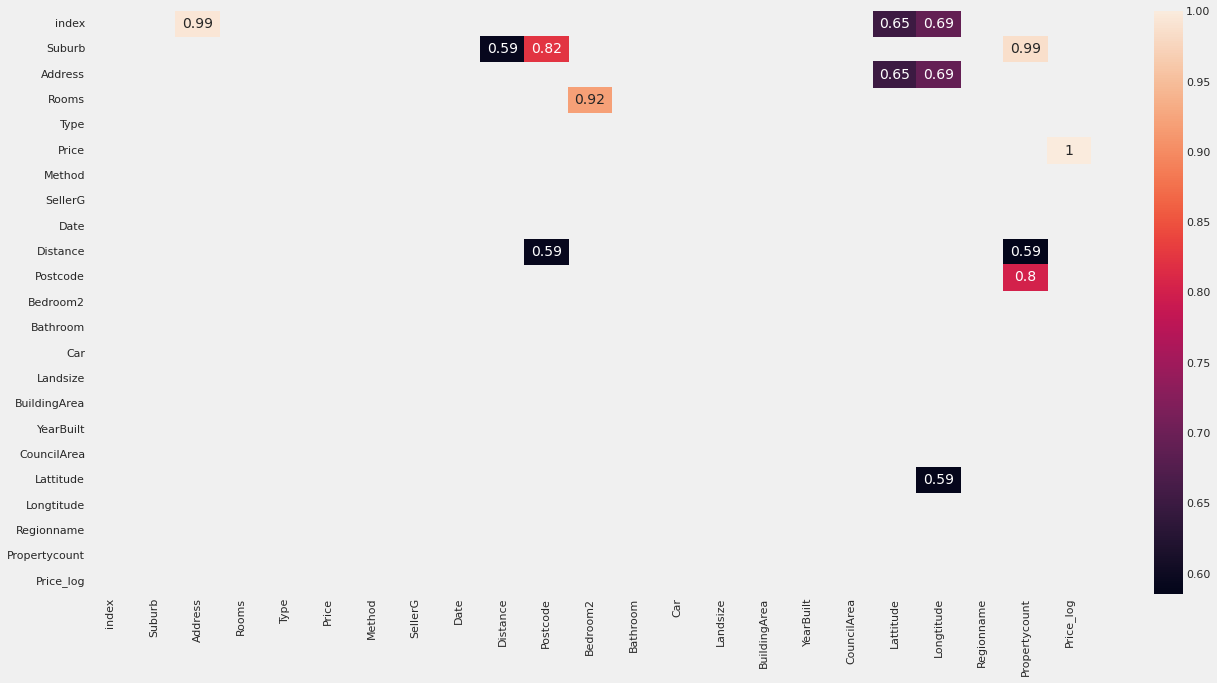

In [ ]:
df1=housing.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
upper_tri = df1.where(np.triu(np.ones(df1.shape),k=1).astype(bool))
upper_tri=upper_tri.apply(lambda x: [np.nan if x < 0.5 else x for x in x])
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(upper_tri,ax=ax, annot=True)

In [ ]:
housing["price_cat"] = pd.cut(housing["Price"],
                               bins=[0., 500000, 1000000, 1500000, 2000000., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing["price_cat"].value_counts()

1    5432
2       0
3       0
4       0
5       0
Name: price_cat, dtype: int64

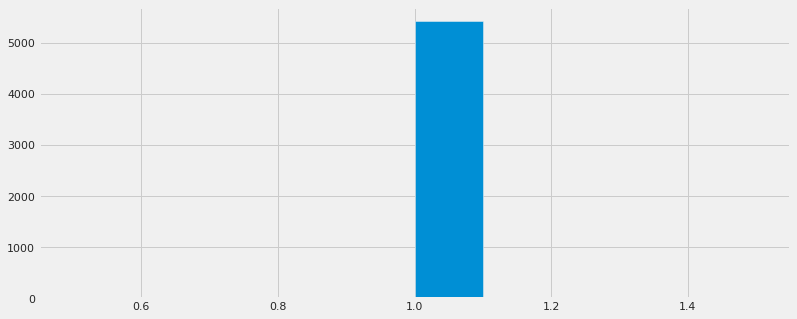

In [ ]:
housing["price_cat"].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["price_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
strat_test_set["price_cat"].value_counts() / len(strat_test_set)


1    1.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: price_cat, dtype: float64

In [ ]:
housing["price_cat"].value_counts() / len(housing)

1    1.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: price_cat, dtype: float64

In [ ]:
def price_cat_proportions(data):
    return data["price_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": price_cat_proportions(housing),
    "Stratified": price_cat_proportions(strat_test_set),
    "Random": price_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [ ]:
## check the proportion of each category with the different approaches
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,1.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,NaN,NaN
3,0.0,0.0,0.0,NaN,NaN
4,0.0,0.0,0.0,NaN,NaN
5,0.0,0.0,0.0,NaN,NaN


In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("price_cat", axis=1, inplace=True)

## Discover and visualize the data to gain insights

In [ ]:
housing = strat_train_set.copy()

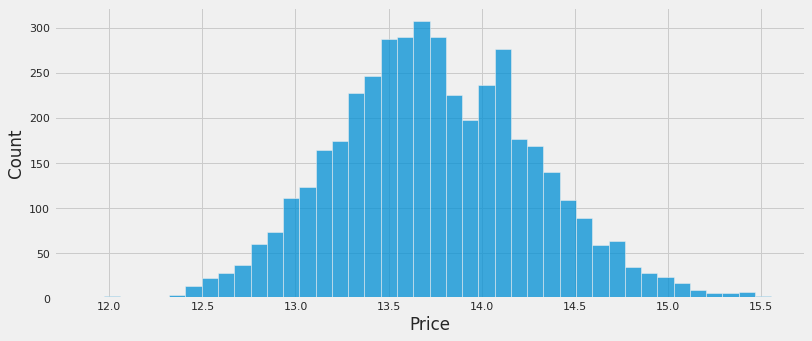

In [ ]:
sns.histplot(train_set["Price"])
plt.show()

In [ ]:
# We can check how many different type there is in the dataset using the folliwing line
train_set["Type"].value_counts()

h    3014
u     944
t     387
Name: Type, dtype: int64

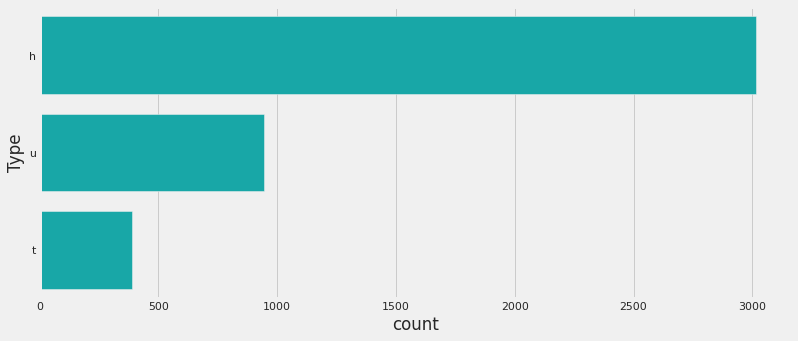

In [ ]:
sns.countplot(y="Type", data=train_set, color="c")

In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix["Price"].sort_values(ascending=False)

Price            1.000000
Price_log        1.000000
Rooms            0.562770
Bedroom2         0.524854
Bathroom         0.453438
Car              0.250348
Longtitude       0.247423
BuildingArea     0.065814
Landsize         0.053686
index           -0.012682
Propertycount   -0.062270
Distance        -0.152046
Lattitude       -0.218232
Name: Price, dtype: float64

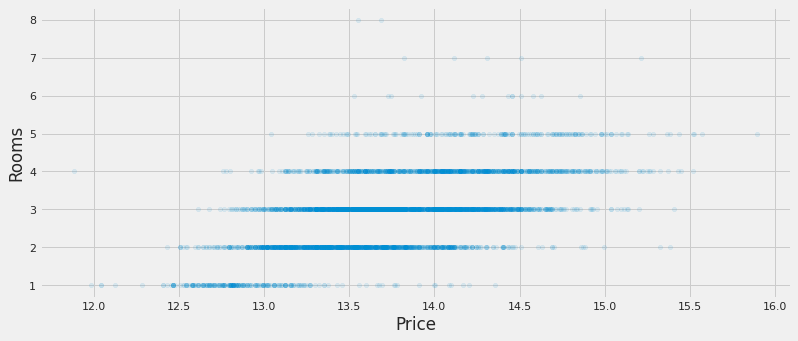

In [ ]:
housing.plot(kind="scatter", x="Price", y="Rooms",
             alpha=0.1)
plt.show()

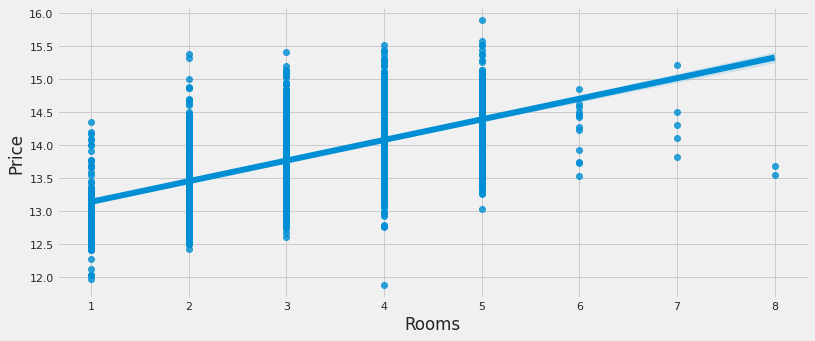

In [ ]:
sns.regplot(data=housing, x="Rooms", y="Price")
plt.show()

In [ ]:
## Plot landsize vs Price

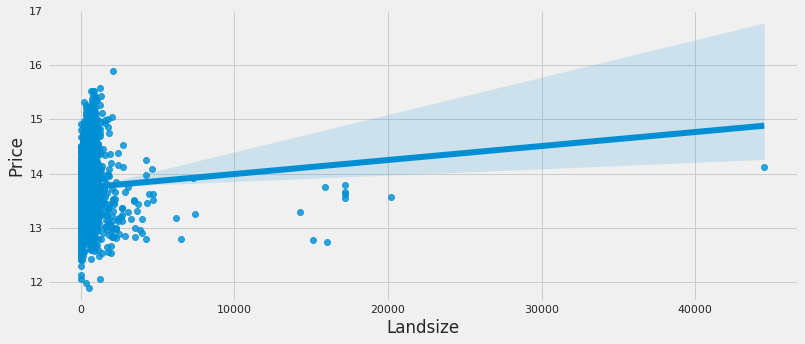

In [ ]:
sns.regplot(data=housing, x="Landsize", y="Price")
plt.show()

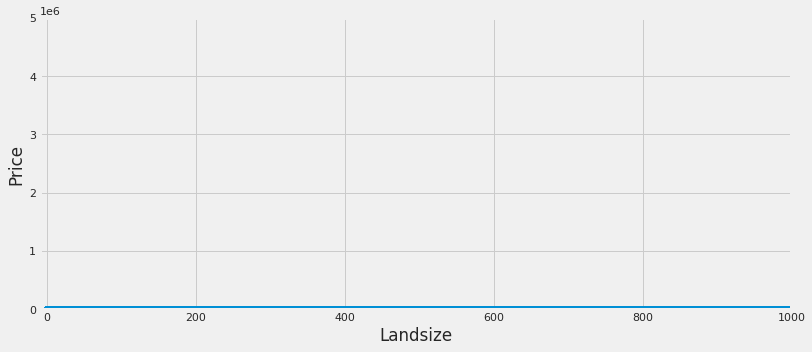

In [ ]:
sns.regplot(data=housing, x="Landsize", y="Price")
plt.axis([-10, 1000, 0, 5e6])
plt.show()

In [ ]:
## mmm there is a lot of 0 at Landsize.... 

In [ ]:
## Let's see BuildingArea

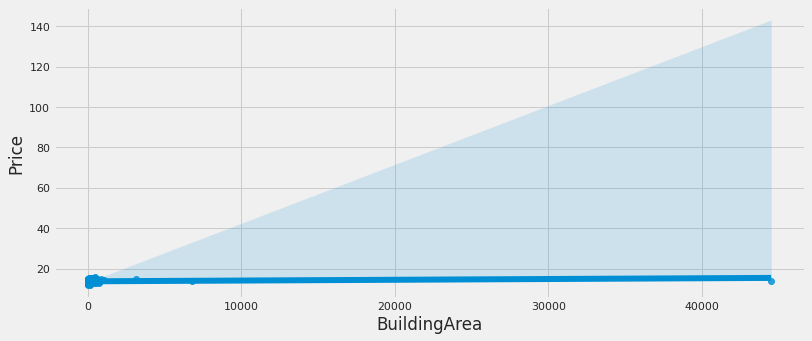

In [ ]:
sns.regplot(data=housing, x="BuildingArea", y="Price")
plt.show()

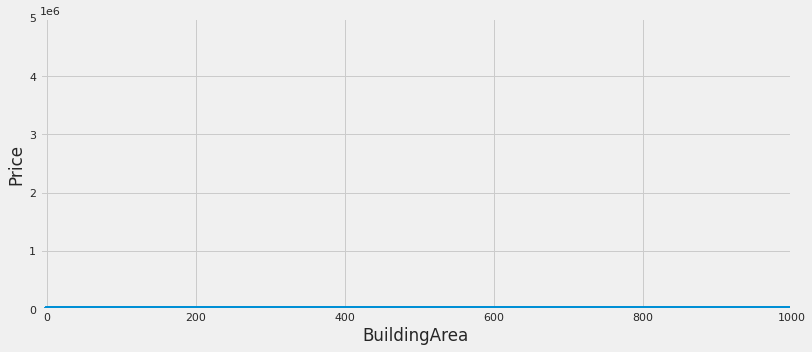

In [ ]:
sns.regplot(data=housing, x="BuildingArea", y="Price",)
plt.axis([-10, 1000, 0, 5e6])
plt.show()

In [ ]:
## Now there is no 0 but NaNs.. NaNs are not displayed, neither taked into account to estimate the fit

In [ ]:
housing[['Price','Landsize','BuildingArea']].head(10)

,Price,Landsize,BuildingArea
2687,13.458836,697.0,NaN
4703,14.038654,297.0,234.0
3264,14.920767,715.0,420.0
3944,13.885969,182.0,NaN
3130,14.690979,1110.0,NaN
2297,13.514405,467.0,NaN
354,13.253392,693.0,174.0
4454,13.186277,0.0,NaN
4235,13.334810,542.0,221.0
5019,14.115615,264.0,188.0


In [ ]:
housing.describe()

,index,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Price_log
count,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4323.000000,4345.000000,2304.000000,4345.000000,4345.000000,4345.000000,4345.000000
mean,2698.466283,2.930035,13.745841,10.203360,2.908861,1.540852,1.625492,514.603682,167.077768,-37.810253,144.995078,7420.017261,13.745841
std,1576.747261,0.959676,0.531631,6.025442,0.998146,0.701386,0.990313,1104.187584,940.836111,0.079353,0.106399,4346.898069,0.531631
min,0.000000,1.000000,11.884489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-38.174880,144.542370,389.000000,11.884489
25%,1335.000000,2.000000,13.384728,6.200000,2.000000,1.000000,1.000000,180.000000,92.000000,-37.857200,144.931900,4217.000000,13.384728
50%,2670.000000,3.000000,13.710150,9.200000,3.000000,1.000000,2.000000,450.000000,125.000000,-37.803900,145.000600,6543.000000,13.710150
75%,4065.000000,3.000000,14.097677,13.000000,3.000000,2.000000,2.000000,655.000000,175.000000,-37.757000,145.059630,10331.000000,14.097677
max,5431.000000,8.000000,15.894952,48.100000,20.000000,6.000000,10.000000,44500.000000,44515.000000,-37.408530,145.526350,21650.000000,15.894952


## Prepare the data for Machine Learning algorithms

In [ ]:
housing = strat_train_set.drop("Price", axis=1) # drop labels for training set
housing_labels = strat_train_set["Price"].copy()

### Data Cleaning 

What to do with data with missing values
* Option 1: Remove rows
* Option 2: Remove columns
* Option 3: Impute missing values

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]
print(housing.shape[0],sample_incomplete_rows.shape[0])
sample_incomplete_rows.head()

4345 2272


,index,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
2687,2687,Albion,76 Forrest St,3,h,S,Douglas,13/05/2017,13.9,3020.0,3.0,1.0,2.0,697.0,NaN,nan,Brimbank,-37.78410,144.81690,Western Metropolitan,2185.0,13.458836
3944,3944,Brunswick,30 Mountfield St,2,h,S,Jellis,28/08/2016,5.2,3056.0,2.0,1.0,1.0,182.0,NaN,nan,Moreland,-37.76290,144.96800,Northern Metropolitan,11918.0,13.885969
3130,3130,Ivanhoe,19 Belmont Rd,2,h,S,Fletchers,12/08/2017,7.8,3079.0,2.0,1.0,0.0,1110.0,NaN,nan,Banyule,-37.76778,145.03312,Eastern Metropolitan,5549.0,14.690979
2297,2297,Thornbury,296 Gooch St,2,h,S,Harcourts,14/05/2016,6.5,3071.0,3.0,1.0,2.0,467.0,NaN,nan,Darebin,-37.76060,145.02410,Northern Metropolitan,8870.0,13.514405
354,354,Sunbury,20 Brett Ct,4,h,S,Barry,3/09/2017,31.7,3429.0,4.0,2.0,2.0,693.0,174.0,1995.0,NaN,-37.57029,144.71163,Western Metropolitan,14092.0,13.253392


In [ ]:
# # option 1 : remove those rows with nans 
cols_wiht_nans = housing.columns[housing.isna().any()].tolist()
housing.dropna()    

,index,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
4703,4703,Thornbury,50b Clyde St,3,h,VB,Nelson,24/09/2016,6.5,3071.0,3.0,2.0,3.0,297.0,234.0,2013.0,Darebin,-37.76170,145.01170,Northern Metropolitan,8870.0,14.038654
3264,3264,Balwyn,112 Belmore Rd,5,h,PI,Jellis,28/05/2016,9.7,3103.0,5.0,3.0,2.0,715.0,420.0,2009.0,Boroondara,-37.80280,145.07680,Southern Metropolitan,5682.0,14.920767
4235,4235,Hillside,20 Viridian Dr,4,h,S,YPA,29/07/2017,18.0,3037.0,4.0,2.0,2.0,542.0,221.0,2009.0,Melton,-37.68104,144.74608,Western Metropolitan,5556.0,13.334810
3085,3085,Abbotsford,133 Yarra St,2,h,S,Biggin,22/07/2017,3.0,3067.0,2.0,2.0,1.0,147.0,175.0,2000.0,Yarra,-37.80269,145.00010,Northern Metropolitan,4019.0,13.989464
507,507,Fitzroy North,236 Barkly St,2,h,S,Chambers,29/04/2017,3.5,3068.0,2.0,1.0,0.0,192.0,85.2,1910.0,Yarra,-37.77930,144.98790,Northern Metropolitan,6244.0,13.869051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4382,4382,Williamstown,73 Victoria St,4,h,PI,Sweeney,8/10/2016,8.0,3016.0,4.0,3.0,2.0,321.0,287.0,nan,Hobsons Bay,-37.86230,144.88840,Western Metropolitan,6380.0,14.411596
1235,1235,West Footscray,1/37 Hampton Pde,3,h,S,Village,10/09/2016,8.2,3012.0,3.0,1.0,2.0,302.0,125.0,1938.0,Maribyrnong,-37.80660,144.86660,Western Metropolitan,5058.0,13.491165
3845,3845,Brighton East,3/127 Dendy St,2,u,S,Buxton,26/07/2016,10.7,3187.0,2.0,1.0,1.0,74.0,66.0,1960.0,Bayside,-37.92070,145.00790,Southern Metropolitan,6938.0,13.447341
4030,4030,Oak Park,10 Grevillia Rd,5,h,PI,Nelson,12/11/2016,11.5,3046.0,5.0,2.0,4.0,783.0,223.0,1950.0,Moreland,-37.72070,144.92630,Northern Metropolitan,2651.0,13.910821


In [ ]:
# only from a subset of columns
cols_wiht_nans = housing.columns[housing.isna().any()].tolist()
housing.dropna(subset=["BuildingArea"])    

,index,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
4703,4703,Thornbury,50b Clyde St,3,h,VB,Nelson,24/09/2016,6.5,3071.0,3.0,2.0,3.0,297.0,234.0,2013.0,Darebin,-37.76170,145.01170,Northern Metropolitan,8870.0,14.038654
3264,3264,Balwyn,112 Belmore Rd,5,h,PI,Jellis,28/05/2016,9.7,3103.0,5.0,3.0,2.0,715.0,420.0,2009.0,Boroondara,-37.80280,145.07680,Southern Metropolitan,5682.0,14.920767
354,354,Sunbury,20 Brett Ct,4,h,S,Barry,3/09/2017,31.7,3429.0,4.0,2.0,2.0,693.0,174.0,1995.0,NaN,-37.57029,144.71163,Western Metropolitan,14092.0,13.253392
4235,4235,Hillside,20 Viridian Dr,4,h,S,YPA,29/07/2017,18.0,3037.0,4.0,2.0,2.0,542.0,221.0,2009.0,Melton,-37.68104,144.74608,Western Metropolitan,5556.0,13.334810
5019,5019,Northcote,39 Winifred St,4,h,S,Ray,23/09/2017,5.3,3070.0,4.0,2.0,2.0,264.0,188.0,1996.0,NaN,-37.76898,144.98580,Northern Metropolitan,11364.0,14.115615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4382,4382,Williamstown,73 Victoria St,4,h,PI,Sweeney,8/10/2016,8.0,3016.0,4.0,3.0,2.0,321.0,287.0,nan,Hobsons Bay,-37.86230,144.88840,Western Metropolitan,6380.0,14.411596
1235,1235,West Footscray,1/37 Hampton Pde,3,h,S,Village,10/09/2016,8.2,3012.0,3.0,1.0,2.0,302.0,125.0,1938.0,Maribyrnong,-37.80660,144.86660,Western Metropolitan,5058.0,13.491165
3845,3845,Brighton East,3/127 Dendy St,2,u,S,Buxton,26/07/2016,10.7,3187.0,2.0,1.0,1.0,74.0,66.0,1960.0,Bayside,-37.92070,145.00790,Southern Metropolitan,6938.0,13.447341
4030,4030,Oak Park,10 Grevillia Rd,5,h,PI,Nelson,12/11/2016,11.5,3046.0,5.0,2.0,4.0,783.0,223.0,1950.0,Moreland,-37.72070,144.92630,Northern Metropolitan,2651.0,13.910821


In [ ]:
## option 2 : remove those columns
cols_wiht_nans = housing.columns[housing.isna().any()].tolist()
housing.drop(cols_wiht_nans, axis=1)       # option 2


,index,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,Price_log
2687,2687,Albion,76 Forrest St,3,h,S,Douglas,13/05/2017,13.9,3020.0,3.0,1.0,697.0,nan,-37.78410,144.81690,Western Metropolitan,2185.0,13.458836
4703,4703,Thornbury,50b Clyde St,3,h,VB,Nelson,24/09/2016,6.5,3071.0,3.0,2.0,297.0,2013.0,-37.76170,145.01170,Northern Metropolitan,8870.0,14.038654
3264,3264,Balwyn,112 Belmore Rd,5,h,PI,Jellis,28/05/2016,9.7,3103.0,5.0,3.0,715.0,2009.0,-37.80280,145.07680,Southern Metropolitan,5682.0,14.920767
3944,3944,Brunswick,30 Mountfield St,2,h,S,Jellis,28/08/2016,5.2,3056.0,2.0,1.0,182.0,nan,-37.76290,144.96800,Northern Metropolitan,11918.0,13.885969
3130,3130,Ivanhoe,19 Belmont Rd,2,h,S,Fletchers,12/08/2017,7.8,3079.0,2.0,1.0,1110.0,nan,-37.76778,145.03312,Eastern Metropolitan,5549.0,14.690979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3845,3845,Brighton East,3/127 Dendy St,2,u,S,Buxton,26/07/2016,10.7,3187.0,2.0,1.0,74.0,1960.0,-37.92070,145.00790,Southern Metropolitan,6938.0,13.447341
4030,4030,Oak Park,10 Grevillia Rd,5,h,PI,Nelson,12/11/2016,11.5,3046.0,5.0,2.0,783.0,1950.0,-37.72070,144.92630,Northern Metropolitan,2651.0,13.910821
2428,2428,Carnegie,33 McLaurin Rd,3,h,S,hockingstuart,17/09/2016,11.4,3163.0,3.0,2.0,554.0,nan,-37.89340,145.05990,Southern Metropolitan,7822.0,14.166167
4769,4769,Keilor East,16 Drew St,3,h,S,Nelson,4/03/2017,12.8,3033.0,3.0,1.0,662.0,nan,-37.73800,144.86900,Western Metropolitan,5629.0,13.748302


In [ ]:
## option 3 : Set values to some values
median = housing["BuildingArea"].median()
housing["BuildingArea"].fillna(median, inplace=True) 
housing.head()

,index,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
2687,2687,Albion,76 Forrest St,3,h,S,Douglas,13/05/2017,13.9,3020.0,3.0,1.0,2.0,697.0,125.0,nan,Brimbank,-37.78410,144.81690,Western Metropolitan,2185.0,13.458836
4703,4703,Thornbury,50b Clyde St,3,h,VB,Nelson,24/09/2016,6.5,3071.0,3.0,2.0,3.0,297.0,234.0,2013.0,Darebin,-37.76170,145.01170,Northern Metropolitan,8870.0,14.038654
3264,3264,Balwyn,112 Belmore Rd,5,h,PI,Jellis,28/05/2016,9.7,3103.0,5.0,3.0,2.0,715.0,420.0,2009.0,Boroondara,-37.80280,145.07680,Southern Metropolitan,5682.0,14.920767
3944,3944,Brunswick,30 Mountfield St,2,h,S,Jellis,28/08/2016,5.2,3056.0,2.0,1.0,1.0,182.0,125.0,nan,Moreland,-37.76290,144.96800,Northern Metropolitan,11918.0,13.885969
3130,3130,Ivanhoe,19 Belmont Rd,2,h,S,Fletchers,12/08/2017,7.8,3079.0,2.0,1.0,0.0,1110.0,125.0,nan,Banyule,-37.76778,145.03312,Eastern Metropolitan,5549.0,14.690979


In [ ]:
median = housing["YearBuilt"].median()
housing["YearBuilt"].fillna(median, inplace=True) 
housing.head()

,index,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
2687,2687,Albion,76 Forrest St,3,h,S,Douglas,13/05/2017,13.9,3020.0,3.0,1.0,2.0,697.0,125.0,nan,Brimbank,-37.78410,144.81690,Western Metropolitan,2185.0,13.458836
4703,4703,Thornbury,50b Clyde St,3,h,VB,Nelson,24/09/2016,6.5,3071.0,3.0,2.0,3.0,297.0,234.0,2013.0,Darebin,-37.76170,145.01170,Northern Metropolitan,8870.0,14.038654
3264,3264,Balwyn,112 Belmore Rd,5,h,PI,Jellis,28/05/2016,9.7,3103.0,5.0,3.0,2.0,715.0,420.0,2009.0,Boroondara,-37.80280,145.07680,Southern Metropolitan,5682.0,14.920767
3944,3944,Brunswick,30 Mountfield St,2,h,S,Jellis,28/08/2016,5.2,3056.0,2.0,1.0,1.0,182.0,125.0,nan,Moreland,-37.76290,144.96800,Northern Metropolitan,11918.0,13.885969
3130,3130,Ivanhoe,19 Belmont Rd,2,h,S,Fletchers,12/08/2017,7.8,3079.0,2.0,1.0,0.0,1110.0,125.0,nan,Banyule,-37.76778,145.03312,Eastern Metropolitan,5549.0,14.690979


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [ ]:
housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)
imputer.statistics_

array([ 2.670000e+03,  3.000000e+00,  9.200000e+00,  3.000000e+00,
        1.000000e+00,  2.000000e+00,  4.500000e+02,  1.250000e+02,
       -3.780390e+01,  1.450006e+02,  6.543000e+03,  1.371015e+01])

Check that this is the same as manually computing the median of each attribute:

In [ ]:
housing_num.median().values

array([ 2.670000e+03,  3.000000e+00,  9.200000e+00,  3.000000e+00,
        1.000000e+00,  2.000000e+00,  4.500000e+02,  1.250000e+02,
       -3.780390e+01,  1.450006e+02,  6.543000e+03,  1.371015e+01])

Transform the training set:



In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]


,index,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Price_log
2687,2687.0,3.0,13.9,3.0,1.0,2.0,697.0,125.0,-37.78410,144.81690,2185.0,13.458836
3944,3944.0,2.0,5.2,2.0,1.0,1.0,182.0,125.0,-37.76290,144.96800,11918.0,13.885969
3130,3130.0,2.0,7.8,2.0,1.0,0.0,1110.0,125.0,-37.76778,145.03312,5549.0,14.690979
2297,2297.0,2.0,6.5,3.0,1.0,2.0,467.0,125.0,-37.76060,145.02410,8870.0,13.514405
354,354.0,4.0,31.7,4.0,2.0,2.0,693.0,174.0,-37.57029,144.71163,14092.0,13.253392
...,...,...,...,...,...,...,...,...,...,...,...,...
2074,2074.0,3.0,14.5,3.0,1.0,1.0,538.0,125.0,-37.70178,145.08510,1442.0,13.465953
1199,1199.0,2.0,19.6,2.0,2.0,1.0,149.0,125.0,-37.63110,145.02320,10926.0,12.902963
3641,3641.0,3.0,13.9,3.0,2.0,1.0,300.0,125.0,-37.91890,145.05840,10969.0,13.576619
2428,2428.0,3.0,11.4,3.0,2.0,2.0,554.0,125.0,-37.89340,145.05990,7822.0,14.166167


In [ ]:
imputer.strategy


'median'

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [ ]:
housing_tr.head()

,index,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Price_log
2687,2687.0,3.0,13.9,3.0,1.0,2.0,697.0,125.0,-37.78410,144.81690,2185.0,13.458836
4703,4703.0,3.0,6.5,3.0,2.0,3.0,297.0,234.0,-37.76170,145.01170,8870.0,14.038654
3264,3264.0,5.0,9.7,5.0,3.0,2.0,715.0,420.0,-37.80280,145.07680,5682.0,14.920767
3944,3944.0,2.0,5.2,2.0,1.0,1.0,182.0,125.0,-37.76290,144.96800,11918.0,13.885969
3130,3130.0,2.0,7.8,2.0,1.0,0.0,1110.0,125.0,-37.76778,145.03312,5549.0,14.690979


### Categorical data

Now let's preprocess the categorical input feature, CouncilArea:

In [ ]:
housing_cat = housing[["CouncilArea"]]
# There is missing values in this category, we will create a new cateogry for those.
housing_cat.fillna('Unknown').head(10)

,CouncilArea
2687,Brimbank
4703,Darebin
3264,Boroondara
3944,Moreland
3130,Banyule
2297,Darebin
354,Unknown
4454,Yarra
4235,Melton
5019,Unknown


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat.fillna('Unknown'))
housing_cat_encoded[:10]

array([[ 3.],
       [ 6.],
       [ 2.],
       [22.],
       [ 0.],
       [ 6.],
       [27.],
       [31.],
       [19.],
       [27.]])

In [ ]:
ordinal_encoder.categories_

[array(['Banyule', 'Bayside', 'Boroondara', 'Brimbank', 'Cardinia',
        'Casey', 'Darebin', 'Frankston', 'Glen Eira', 'Greater Dandenong',
        'Hobsons Bay', 'Hume', 'Kingston', 'Knox', 'Macedon Ranges',
        'Manningham', 'Maribyrnong', 'Maroondah', 'Melbourne', 'Melton',
        'Monash', 'Moonee Valley', 'Moreland', 'Nillumbik', 'Port Phillip',
        'Stonnington', 'Unavailable', 'Unknown', 'Whitehorse',
        'Whittlesea', 'Wyndham', 'Yarra', 'Yarra Ranges'], dtype=object)]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown='ignore')
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.fillna('Unknown'))
housing_cat_1hot

<4345x33 sparse matrix of type '<class 'numpy.float64'>'
	with 4345 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Alternatively, you can set sparse=False when creating the OneHotEncoder:

In [ ]:
cat_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.fillna('Unknown'))
housing_cat_1hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
cat_encoder.categories_

[array(['Banyule', 'Bayside', 'Boroondara', 'Brimbank', 'Cardinia',
        'Casey', 'Darebin', 'Frankston', 'Glen Eira', 'Greater Dandenong',
        'Hobsons Bay', 'Hume', 'Kingston', 'Knox', 'Macedon Ranges',
        'Manningham', 'Maribyrnong', 'Maroondah', 'Melbourne', 'Melton',
        'Monash', 'Moonee Valley', 'Moreland', 'Nillumbik', 'Port Phillip',
        'Stonnington', 'Unavailable', 'Unknown', 'Whitehorse',
        'Whittlesea', 'Wyndham', 'Yarra', 'Yarra Ranges'], dtype=object)]

Let's create a custom transformer to add extra attributes:


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
Rooms_ix, Bedroom2_ix, Bathroom_ix, BuildingArea_ix = 0, 2, 3, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        rooms_per_building_area = X[:, Rooms_ix] / (1.0 +X[:, BuildingArea_ix])# add 1 to avoid 0 division
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, Bedroom2_ix] / (1.0 + X[:, Bathroom_ix]) # add 1 to avoid 0 division
            return np.c_[X, rooms_per_building_area, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_building_area]
        

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing_num.values)

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing_num.columns)+["rooms_per_building_area", "bedrooms_per_room"],
    index=housing.index)
housing_extra_attribs.head()

,index,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Price_log,rooms_per_building_area,bedrooms_per_room
2687,2687.0,3.0,13.9,3.0,1.0,2.0,697.0,125.0,-37.78410,144.81690,2185.0,13.458836,3.849570,3.475000
4703,4703.0,3.0,6.5,3.0,2.0,3.0,297.0,234.0,-37.76170,145.01170,8870.0,14.038654,15.781879,1.625000
3264,3264.0,5.0,9.7,5.0,3.0,2.0,715.0,420.0,-37.80280,145.07680,5682.0,14.920767,4.558659,1.616667
3944,3944.0,2.0,5.2,2.0,1.0,1.0,182.0,125.0,-37.76290,144.96800,11918.0,13.885969,21.551913,1.733333
3130,3130.0,2.0,7.8,2.0,1.0,0.0,1110.0,125.0,-37.76778,145.03312,5549.0,14.690979,2.817282,2.600000


Now let's build a pipeline for preprocessing the numerical attributes:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


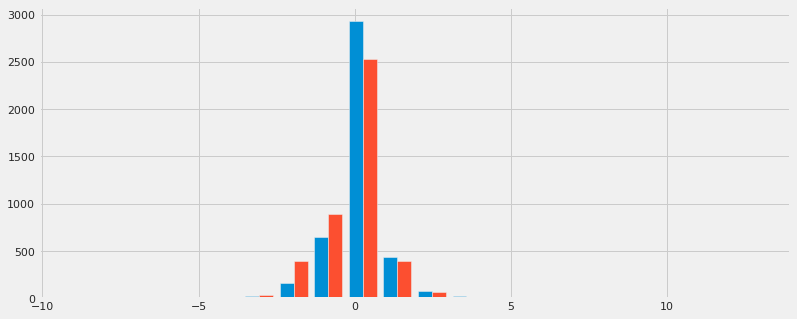

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer


## create a function to replace 0 by NaN
def replace_0_2_NaN(data):
    data[data == 0] = np.nan
    return data


num0_pipeline = Pipeline([
        ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
        ('imputer', SimpleImputer(strategy="median")),
        ('log',FunctionTransformer(np.log1p, validate=True)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num0_pipeline.fit_transform(housing[['BuildingArea','Landsize']])
plt.hist(housing_num_tr,bins=20)
plt.show()

In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

array([[-0.00727295,  0.07291368,  0.61357574, ..., -0.53991973,
        -0.34330027,  0.54844326],
       [ 1.27145579,  0.07291368, -0.61469121, ...,  0.55084612,
        -0.33224969, -0.68790729],
       [ 0.35871241,  2.15718973, -0.08354874, ...,  2.21029481,
        -0.34264358, -0.69347644],
       ...,
       [-0.17155407,  0.07291368,  0.19862069, ...,  0.79072666,
        -0.34281387,  0.13075726],
       [ 1.31331893,  0.07291368,  0.43099552, ...,  0.00462971,
        -0.34020384,  0.36466142],
       [ 1.07355729, -0.96922434, -0.93005704, ..., -1.17289786,
         3.7196638 , -0.7491679 ]])

In [ ]:
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs0 = ['Landsize','BuildingArea']
num_attribs1 = list(housing_num)
cat_attribs = ["CouncilArea",'Type','Suburb','Postcode']


full_pipeline = ColumnTransformer([
        ("num0", num0_pipeline, num_attribs0),
        ("num1", num_pipeline, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

housing_prepared

<4345x523 sparse matrix of type '<class 'numpy.float64'>'
	with 86900 stored elements in Compressed Sparse Row format>

## Select and train a model

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:25]
some_labels = housing_labels.iloc[:25]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [13.45883562 14.03865415 14.92076729 13.88596906 14.69097928 13.51440556
 13.2533915  13.18627668 13.33480994 14.11561501 13.98946384 13.86905134
 13.24987668 13.92167074 13.17305653 13.48978037 13.6529917  13.26905776
 13.52782852 14.46783577 14.54835917 13.14216597 13.17685159 13.40754229
 14.11561515]


Compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))


Labels: [13.458835614025542, 14.038654109278484, 14.920767389351052, 13.885969021612835, 14.690979295318174, 13.514405465180353, 13.253391639810733, 13.186276703147982, 13.334809919170203, 14.115615150414612, 13.989463865087712, 13.869051324892304, 13.249876697703288, 13.921670753792664, 13.173056491719846, 13.489780417874963, 13.652991628466498, 13.269057756555132, 13.527828485512494, 14.467835744003965, 14.548359105375772, 13.142166004700508, 13.176851562688398, 13.407542319637992, 14.115615150414612]


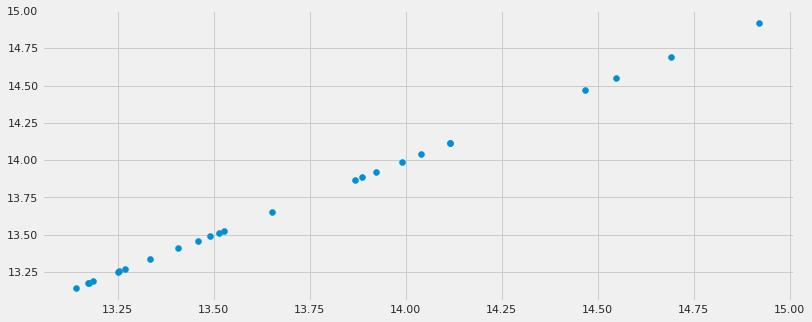

In [ ]:
plt.scatter(lin_reg.predict(some_data_prepared),list(some_labels))

In [ ]:
some_data_prepared

<25x523 sparse matrix of type '<class 'numpy.float64'>'
	with 500 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

9.25531147718212e-08

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

5.013894591130439e-08

### K-Nearest Neighbour

In [ ]:
from sklearn import neighbors

n_neighbors = 3
knn_reg = neighbors.KNeighborsRegressor(n_neighbors)
knn_reg.fit(housing_prepared, housing_labels)

KNeighborsRegressor(n_neighbors=3)

In [ ]:
housing_predictions = knn_reg.predict(housing_prepared)
knn_mse = mean_squared_error(housing_labels, housing_predictions)
knn_rmse = np.sqrt(knn_mse)
knn_rmse


0.14462651648218644

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

2.010332558707222e-15

## Fine-tune your model

Find the best parameters for your model. In order to do so, we will use the 10-fold cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_root_mean_squared_error", cv=10)


In [ ]:
def display_scores(scores,model_name = None):
    if(model_name):
        print("----",model_name,"----")
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(-scores,'Decision Tree')

---- Decision Tree ----
Mean: 0.005933173103229464
Standard deviation: 0.004671038912697486


In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
display_scores(-lin_scores,'Linear Regression')

---- Linear Regression ----
Mean: 1.9815010745611557e-07
Standard deviation: 1.16746521215259e-07


In [ ]:
knn_scores = cross_val_score(knn_reg, housing_prepared, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
display_scores(-knn_scores,'Knn Regression')

---- Knn Regression ----
Mean: 0.20619981306951501
Standard deviation: 0.009204260272628792


In [ ]:
## Let's try another model: SVM
from sklearn.svm import SVR
svm_reg = SVR(kernel="linear")

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)
display_scores(-svm_scores, 'SVM')

---- SVM ----
Mean: 0.0358315439066701
Standard deviation: 0.001362937277252297


In [ ]:
## Let's try another model: Random Forest
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=20, random_state=42)

In [ ]:
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.003521138903682242

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)
display_scores(-forest_scores, 'Random Forest')

---- Random Forest ----
Mean: 0.00655374944694589
Standard deviation: 0.004709679221462577


In [ ]:
results = pd.Series(-forest_scores)

In [ ]:
results.describe()

count    10.000000
mean      0.006554
std       0.004964
min       0.002031
25%       0.003197
50%       0.005771
75%       0.007029
max       0.018749
dtype: float64

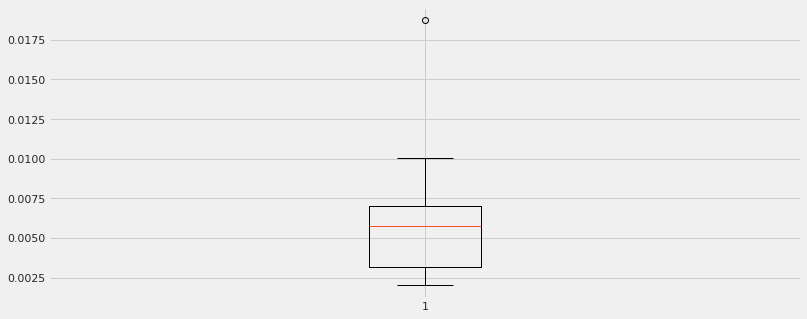

In [ ]:
plt.boxplot(results)
plt.show()

In [ ]:
## lets comare all of them 
models = [(lin_reg,"lin_reg"),
          (tree_reg,"Decision Tree"),
          (knn_reg,"KNN-Regressor"),
          (forest_reg,'Random Forest'),
          (svm_reg,'SVM Regressor')]
for model in models:
    scores = cross_val_score(model[0], housing_prepared, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
    display_scores(-scores, model[1])

---- lin_reg ----
Mean: 1.9815010745611557e-07
Standard deviation: 1.16746521215259e-07
---- Decision Tree ----
Mean: 0.005933173103229464
Standard deviation: 0.004671038912697486
---- KNN-Regressor ----
Mean: 0.20619981306951501
Standard deviation: 0.009204260272628792


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8], 'max_depth':[3,5,7,10]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_depth': [3, 5, 7, 10],
                          'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [ ]:
print("the best parameters are:")
print(grid_search.best_params_)

the best parameters are:
{'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


In [ ]:
print("Best Score")
np.sqrt(-grid_search.best_score_)

Best Score


0.4355227150529172

In [ ]:
print("the best trained model:")
grid_search.best_estimator_

the best trained model:


RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=10,
                      random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.5273331134556808 {'max_depth': 3, 'max_features': 2, 'n_estimators': 3}
0.5201359928524278 {'max_depth': 3, 'max_features': 2, 'n_estimators': 10}
0.5191999260137568 {'max_depth': 3, 'max_features': 2, 'n_estimators': 30}
0.47228559430868833 {'max_depth': 3, 'max_features': 4, 'n_estimators': 3}
0.4992895763199465 {'max_depth': 3, 'max_features': 4, 'n_estimators': 10}
0.4938077438261561 {'max_depth': 3, 'max_features': 4, 'n_estimators': 30}
0.5225558691905141 {'max_depth': 3, 'max_features': 6, 'n_estimators': 3}
0.4860997346565054 {'max_depth': 3, 'max_features': 6, 'n_estimators': 10}
0.4702224894211531 {'max_depth': 3, 'max_features': 6, 'n_estimators': 30}
0.5170675648263734 {'max_depth': 3, 'max_features': 8, 'n_estimators': 3}
0.48996192855370363 {'max_depth': 3, 'max_features': 8, 'n_estimators': 10}
0.4658379568811818 {'max_depth': 3, 'max_features': 8, 'n_estimators': 30}
0.5242616255899673 {'max_depth': 5, 'max_features': 2, 'n_estimators': 3}
0.5061525511094834 {'max_dep

In [ ]:
pd.DataFrame(grid_search.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.009866,0.002008,0.001571,0.000183,3,2,3,NaN,"{'max_depth': 3, 'max_features': 2, 'n_estimat...",-0.523810,-0.534203,-0.523382,-0.537473,-0.517798,-0.527333,0.007334,54,-5.272684e-01,-5.250165e-01,-5.273541e-01,-5.243560e-01,-5.287144e-01,-5.265419e-01,1.613197e-03
1,0.019540,0.001525,0.002440,0.000104,3,2,10,NaN,"{'max_depth': 3, 'max_features': 2, 'n_estimat...",-0.517208,-0.525491,-0.515919,-0.530887,-0.511175,-0.520136,0.007084,51,-5.203226e-01,-5.185290e-01,-5.204146e-01,-5.171388e-01,-5.196507e-01,-5.192111e-01,1.235880e-03
2,0.048945,0.002200,0.004892,0.000315,3,2,30,NaN,"{'max_depth': 3, 'max_features': 2, 'n_estimat...",-0.514354,-0.523879,-0.513653,-0.531615,-0.512498,-0.519200,0.007419,50,-5.172577e-01,-5.152280e-01,-5.177584e-01,-5.178046e-01,-5.222319e-01,-5.180561e-01,2.290187e-03
3,0.010386,0.001436,0.001569,0.000105,3,4,3,NaN,"{'max_depth': 3, 'max_features': 4, 'n_estimat...",-0.502741,-0.511303,-0.501461,-0.432599,-0.413324,-0.472286,0.040872,35,-5.058405e-01,-5.039799e-01,-5.060758e-01,-4.180246e-01,-4.222975e-01,-4.712437e-01,4.173698e-02
4,0.020287,0.000986,0.002735,0.000627,3,4,10,NaN,"{'max_depth': 3, 'max_features': 4, 'n_estimat...",-0.508258,-0.515598,-0.506028,-0.493753,-0.472811,-0.499290,0.014991,45,-5.096946e-01,-5.082517e-01,-5.101133e-01,-4.805228e-01,-4.833547e-01,-4.983874e-01,1.347426e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,0.351695,0.002177,0.006911,0.000157,NaN,2,10,False,"{'bootstrap': False, 'max_features': 2, 'n_est...",-0.210034,-0.214481,-0.203971,-0.219065,-0.206323,-0.210775,0.005461,3,-1.774056e-15,-1.764307e-15,-1.765078e-15,-1.763020e-15,-1.753727e-15,-1.764038e-15,6.463101e-18
50,0.108045,0.003383,0.003088,0.000104,NaN,3,3,False,"{'bootstrap': False, 'max_features': 3, 'n_est...",-0.232059,-0.247637,-0.221522,-0.244522,-0.235264,-0.236201,0.009312,5,-8.758277e-16,-8.590839e-16,-8.674962e-16,-8.716719e-16,-8.753093e-16,-8.698778e-16,6.169295e-18
51,0.347477,0.000905,0.006635,0.000206,NaN,3,10,False,"{'bootstrap': False, 'max_features': 3, 'n_est...",-0.207752,-0.194999,-0.192944,-0.189728,-0.201058,-0.197296,0.006403,2,-1.774056e-15,-1.764307e-15,-1.765078e-15,-1.763020e-15,-1.753727e-15,-1.764038e-15,6.463101e-18
52,0.108144,0.003609,0.003230,0.000599,NaN,4,3,False,"{'bootstrap': False, 'max_features': 4, 'n_est...",-0.239722,-0.220230,-0.229579,-0.223556,-0.215489,-0.225715,0.008372,4,-8.758277e-16,-8.590839e-16,-8.674962e-16,-8.716719e-16,-8.753093e-16,-8.698778e-16,6.169295e-18


In [ ]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42,n_estimators=5,max_depth=10), # from 42 to 10 estimators
                  param_grid={'max_features': range(2, 50, 2)},
                  scoring='neg_root_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
results = grid_search.cv_results_

In [ ]:
#plot the results
plt.figure(figsize=(15, 15))
plt.title("GridSearchCV",
          fontsize=16)

plt.xlabel("max_features")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 50)


# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_features'].data, dtype=float)


for sample, style in (('train', '--'), ('test', '-')):
    sample_score_mean = (-results['mean_%s_score' % (sample)])
    sample_score_std = (results['std_%s_score' % (sample)])
    ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == 'test' else 0)
    ax.plot(X_axis, sample_score_mean, style,
            alpha=1 if sample == 'test' else 0.7,
            label="(%s)" % ( sample))

best_index = np.nonzero(results['rank_test_score' ] == 1)[0][0]
best_score =  (-results['mean_test_score' ][best_index])

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([X_axis[best_index], ] * 2, [best_score, best_score],
        linestyle='-.',  marker='x', markeredgewidth=3, ms=8)

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [ ]:
## Best features according to Random Forest
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ["rooms_per_building_area", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(full_pipeline.named_transformers_["cat"]['one_hot_encoder'].categories_[0])
attributes = ["log_" + t for t in num_attribs0 ] + num_attribs1 + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

 ## Final Model 
 Create Final Model and evaluate it (You shoud do this only once)

In [ ]:
# housing_test = pd.read_csv("/content/train_set.csv")

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("Price", axis=1)
y_test = strat_test_set["Price"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

0.18170077940847262

In [ ]:
# Submission file

output = pd.DataFrame({'Index': X_test.index,
                       'Price': final_predictions})
output.to_csv('submission.csv', index=False)
output.head()

,Index,Price
0,971,13.366869
1,3502,13.266447
2,3498,13.473130
3,474,13.257953
4,2214,13.818807


We can compute a 95% confidence interval for the test RMSE:


In [ ]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

In [ ]:
# create submission file
# submission.to_csv("housing_prediction.csv", index=False)